In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvnorm
import corner
import copy
import multiprocessing as mp
from tqdm import tqdm
from functools import partial

from hmc import HMC
from distributions import UnivariateNormal, IndependentMultivariateNormal, MultivariateNormal, HierarchicalBayesianLogisticRegression

In [2]:
# sns.set()

# Setup

In [3]:
# Get data for dts
def run_dt(data,
           dist, 
           M, 
           n_args, 
           steps,
           N_chains,
           init_x,
           L=5, 
           dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
           prop='leapfrog'):
    results = {}
    times = {}
    for d in dt:
        sampler = HMC(dist.logp, dist.dlogp, dt=d, L=L, M=M, n_args=n_args, prop=prop)
        time0 = time.time()
        xs = sampler.sample_pool(steps, data, N_chains, init_x=init_x, verbose=True)
        times[d] = time.time() - time0
        results[d] = xs
    acc_dict = {}
    for d, xs in results.items():
        acc_chain = []
        for c in range(N_chains):
            acc_chain.append(len(np.unique(xs[c], axis=0)) / xs[c].shape[0])
        acc_dict[d] = np.mean(acc_chain)
    return results, times, acc_dict

def run_L(data,
           dist, 
           M, 
           n_args, 
           steps,
           N_chains,
           init_x,
           Ls=np.arange(3, 8), 
           dt=1e-4, 
           prop='leapfrog'):
    results = {}
    times = {}
    for l in Ls:
        sampler = HMC(dist.logp, dist.dlogp, dt=dt, L=l, M=M, n_args=n_args, prop=prop)
        time0 = time.time()
        xs = sampler.sample_pool(steps, data, N_chains, init_x=init_x, verbose=True)
        times[l] = time.time() - time0
        results[l] = xs
    acc_dict = {}
    for l, xs in results.items():
        acc_chain = []
        for c in range(N_chains):
            acc_chain.append(len(np.unique(xs[c], axis=0)) / xs[c].shape[0])
        acc_dict[l] = np.mean(acc_chain)
    return results, times, acc_dict

In [4]:
def effective_sample_size(x, truncation=True, threshold=0.05):
    # A mapping from sample space to $R$
    # we use mean here
    M = len(x)
    if len(x.shape) > 1:
        f = x.mean(axis=-1)
    else:
        f = x
    
    # Compute mu, sigma
    mu_f = f.mean()
    var_f = f.var()
        
    ess = 0
    ro = np.zeros(M-1)
    temp = f - mu_f
    for s in range(M-1):
        ro[s] = temp[s+1:].dot(temp[:M-s-1]) / (var_f * (M-s-1))
    if truncation:
        M_cutoff = np.argmax(ro < threshold)
        ess = M / (1 + 2 * (1 - np.arange(1, M_cutoff+1) / M).dot(ro[:M_cutoff]))
    else:
        ess = M / (1 + 2 * (1 - np.arange(1, M) / M).dot(ro))
    return ess


"""
Special note: in original "No U-Turn" paper, ESS was computed
in two ways: 1. map from $R^d$ to $R$ then compute the ESS;
2. directly compute ESS on seperate dimensions
"""
def effective_sample_size_on_seperate_dimensions(x, truncation=True, threshold=0.05):
    if len(x.shape) > 1:
        res = []
        for i in range(x.shape[-1]):
            res.append(effective_sample_size(x[:, i]))
        return res
    else:
        return effective_sample_size(x, truncation, threshold)


def average_ess(results):
    ess = {}
    for p, xs in results.items():
        temp = []
        for c in range(N_chains):
            temp.append(effective_sample_size(xs[c]))
        ess[p] = np.mean(temp)
    return ess

In [5]:
N_chains = mp.cpu_count() - 1

In [6]:
# Parameters
dt = [10**c for c in np.arange(-6, -1, dtype=float)]
L = np.arange(3, 8)

# Sampling Example $\mathcal{N}(\mu,\sigma)$

In [7]:
# Generate observed data
truth = (0,1)

N = 10000
data = norm.rvs(loc=truth[0], scale=truth[1], size=N)
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.std(data)}')

mu_hat: 0.00945059906244133, sig_hat: 1.0043583906171232


In [8]:
# Initialize Distribution
dist = UnivariateNormal()

In [9]:
results_uni_dt_lp, times_uni_dt_lp, acc_uni_dt_lp = run_dt(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5],
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='leapfrog'
)

  0%|          | 0/999 [00:00<?, ?it/s]/Users/maho/git/symHMC/hmc.py:157: RuntimeWarning: overflow encountered in exp
  + self.K(v) - self.K(vnew))
/Users/maho/git/symHMC/hmc.py:157: RuntimeWarning: overflow encountered in exp
  + self.K(v) - self.K(vnew))
/Users/maho/git/symHMC/hmc.py:157: RuntimeWarning: overflow encountered in exp
  + self.K(v) - self.K(vnew))
/Users/maho/git/symHMC/hmc.py:157: RuntimeWarning: overflow encountered in exp
  + self.K(v) - self.K(vnew))
/Users/maho/git/symHMC/hmc.py:157: RuntimeWarning: overflow encountered in exp
  + self.K(v) - self.K(vnew))
/Users/maho/git/symHMC/hmc.py:157: RuntimeWarning: overflow encountered in exp
  + self.K(v) - self.K(vnew))
/Users/maho/git/symHMC/hmc.py:157: RuntimeWarning: overflow encountered in exp
  + self.K(v) - self.K(vnew))
100%|██████████| 999/999 [00:03<00:00, 303.27it/s]


In [10]:
results_uni_L_lp, times_uni_L_lp, acc_uni_L_lp = run_L(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5], 
    prop='leapfrog'
)

100%|██████████| 999/999 [00:02<00:00, 417.28it/s]

100%|██████████| 999/999 [00:02<00:00, 356.80it/s]

 99%|█████████▉| 991/999 [00:04<00:00, 189.66it/s]

100%|██████████| 999/999 [00:04<00:00, 211.71it/s]

100%|██████████| 999/999 [00:05<00:00, 180.37it/s]

100%|██████████| 999/999 [00:05<00:00, 177.16it/s]


In [11]:
results_uni_dt_ys, times_uni_dt_ys, acc_uni_dt_ys = run_dt(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5],
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='yoshida'
)

100%|██████████| 999/999 [00:05<00:00, 187.04it/s]

100%|██████████| 999/999 [00:07<00:00, 134.41it/s]

100%|██████████| 999/999 [00:07<00:00, 132.65it/s]


In [12]:
results_uni_L_ys, times_uni_L_ys, acc_uni_L_ys = run_L(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5], 
    prop='yoshida'
)

100%|██████████| 999/999 [00:05<00:00, 182.28it/s]

100%|██████████| 999/999 [00:04<00:00, 232.98it/s]

100%|██████████| 999/999 [00:05<00:00, 176.44it/s]

100%|██████████| 999/999 [00:05<00:00, 176.34it/s]


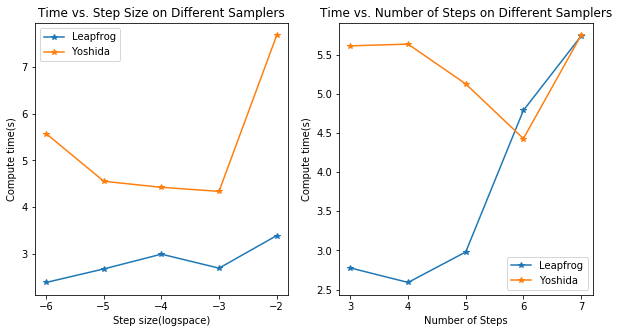

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_uni_dt_lp.keys())), list(times_uni_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_uni_dt_ys.keys())), list(times_uni_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_uni_L_lp.keys()), list(times_uni_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_uni_L_ys.keys()), list(times_uni_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
mpl.rcParams.update({'font.size': 15})

In [14]:
average_ess(results_uni_dt_lp)

{1e-06: 2.916499224805816,
 1e-05: 3.093975856100065,
 0.0001: 26.45761640535907,
 0.001: 780.6726589890924,
 0.01: 1000.0}

In [15]:
average_ess(results_uni_dt_ys)

{1e-06: 2.8915137671602626,
 1e-05: 3.1052133269554525,
 0.0001: 27.248265819096563,
 0.001: 1000.0,
 0.01: 1000.0}

In [16]:
average_ess(results_uni_L_lp) 

{3: 11.336120871817768,
 4: 19.824699984266903,
 5: 22.410692523519696,
 6: 42.81734958105691,
 7: 44.53356172109017}

In [17]:
average_ess(results_uni_L_ys) 

{3: 10.175692096263171,
 4: 19.511261246638124,
 5: 25.35152353865016,
 6: 36.11380188632924,
 7: 42.064098570674936}

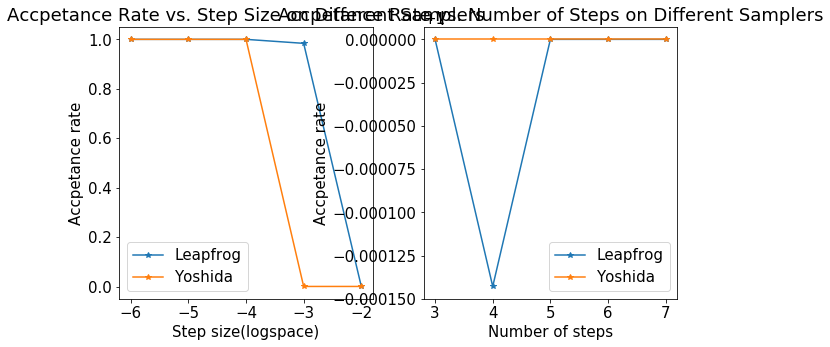

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_uni_dt_lp.keys())), list(acc_uni_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_uni_dt_ys.keys())), list(acc_uni_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_uni_L_lp.keys()), list(acc_uni_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_uni_L_ys.keys()), list(acc_uni_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
mpl.rc('font', size=19)

# Diagonal Multivariate Gaussian

In [19]:
# Generate observed data
ndims = 5 # Number of dimensions for multivariate Gaussian

mu_tru = 10*np.random.rand(ndims)
sig_tru = 5*np.random.rand(ndims)
N_chains = 3
N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.diag(sig_tru), size=N)

print(f'mu_*: {mu_tru}, sig_*: {np.diag(sig_tru)}')
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.cov(data)}')

mu_*: [2.11719859 2.28631523 6.90559354 4.55882134 9.07059544], sig_*: [[0.92020703 0.         0.         0.         0.        ]
 [0.         0.61455942 0.         0.         0.        ]
 [0.         0.         4.74807833 0.         0.        ]
 [0.         0.         0.         0.14956059 0.        ]
 [0.         0.         0.         0.         2.31637544]]
mu_hat: 4.985888439677919, sig_hat: [[13.19726863 13.29050058  3.29278254 ... 11.90586179 14.67173391
  14.22255142]
 [13.29050058 14.51988768  2.10266253 ... 10.77194768 15.15224257
  14.43203331]
 [ 3.29278254  2.10266253  5.8381086  ...  7.84130833  3.72281225
   4.30814391]
 ...
 [11.90586179 10.77194768  7.84130833 ... 15.50254904 13.1812816
  13.53723489]
 [14.67173391 15.15224257  3.72281225 ... 13.1812816  16.79796469
  16.0112982 ]
 [14.22255142 14.43203331  4.30814391 ... 13.53723489 16.0112982
  15.5538802 ]]


In [20]:
# Initialize Distribution
dist = IndependentMultivariateNormal(n_dims=ndims)

In [22]:
results_ind_dt_lp, times_ind_dt_lp, acc_ind_dt_lp = run_dt(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=3,#N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   L=5, 
   dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
   prop='leapfrog'
)


100%|██████████| 999/999 [00:07<00:00, 134.94it/s]


KeyboardInterrupt: 

In [ ]:
def average_ess(results):
    ess = {}
    for p, xs in results.items():
        temp = []
        for c in range(N_chains):
            temp.append(effective_sample_size_on_seperate_dimensions(xs[c]))
        ess[p] = np.mean(temp)
    return ess

In [ ]:
average_ess(results_ind_dt_lp)

In [ ]:
results_ind_L_lp, times_ind_L_lp, acc_ind_L_lp = run_L(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   prop='leapfrog'
)

In [ ]:
average_ess(results_ind_L_lp)

In [ ]:
results_ind_dt_ys, times_ind_dt_ys, acc_ind_dt_ys = run_dt(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   L=5, 
   dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
   prop='yoshida'
)

In [ ]:
average_ess(results_ind_dt_ys)

In [ ]:
results_ind_L_ys, times_ind_L_ys, acc_ind_L_ys = run_L(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   prop='yoshida'
)

In [ ]:
import matplotlib

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_ind_dt_lp.keys())), list(times_ind_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_ind_dt_ys.keys())), list(times_ind_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_ind_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_ind_L_lp.keys()), list(times_ind_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_ind_L_ys.keys()), list(times_ind_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_ind_L_ys.keys()))
matplotlib.rcParams.update({'font.size': 40})

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_ind_dt_lp.keys())), list(acc_ind_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_ind_dt_ys.keys())), list(acc_ind_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_ind_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_ind_L_lp.keys()), list(acc_ind_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_ind_L_ys.keys()), list(acc_ind_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_ind_L_ys.keys()))

 # Sample **HLR**

In [ ]:
# Read data
data = np.loadtxt('UCI_processed_data.txt')

In [ ]:
# Initialize Distribution
dist = HierarchicalBayesianLogisticRegression(300)

In [ ]:
init_x = np.random.randn(302)
init_x[-1] = 100

In [ ]:
results_hlr_dt_lp, times_hlr_dt_lp, acc_hlr_dt_lp = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='leapfrog'
)

In [ ]:
times_uni_dt_lp

In [ ]:
results_hlr_dt_ys, times_hlr_dt_ys, acc_hlr_dt_ys = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='yoshida'
)

In [ ]:
results_hlr_dt_rt, times_hlr_dt_rt, acc_hlr_dt_rt = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='ruth'
)

In [ ]:
results_hlr_dt_ca, times_hlr_dt_ca, acc_hlr_dt_ca = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='calvo'
)

In [ ]:
results_hlr_L_lp, times_hlr_L_lp, acc_hlr_L_lp = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='leapfrog'
)

In [ ]:
results_hlr_L_ys, times_hlr_L_ys, acc_hlr_L_ys = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='yoshida'
)

In [ ]:
results_hlr_L_rt, times_hlr_L_rt, acc_hlr_L_rt = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='ruth'
)

In [ ]:
results_hlr_L_ca, times_hlr_L_ca, acc_hlr_L_ca = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='calvo'
)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_hlr_dt_lp.keys())), list(times_hlr_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_hlr_dt_ys.keys())), list(times_hlr_dt_ys.values()), '-*', label='Yoshida')
ax1.plot(np.log10(list(times_hlr_dt_rt.keys())), list(times_hlr_dt_rt.values()), '-*', label='Ruth')
ax1.plot(np.log10(list(times_hlr_dt_ca.keys())), list(times_hlr_dt_ca.values()), '-*', label='Calvo')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_hlr_L_lp.keys()), list(times_hlr_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_hlr_L_ys.keys()), list(times_hlr_L_ys.values()), '-*', label='Yoshida')
ax2.plot(list(times_hlr_L_rt.keys()), list(times_hlr_L_rt.values()), '-*', label='Ruth')
ax2.plot(list(times_hlr_L_ca.keys()), list(times_hlr_L_ca.values()), '-*', label='Calvo')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
matplotlib.rcParams.update({'font.size': 15})

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_hlr_dt_lp.keys())), list(acc_hlr_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_hlr_dt_ys.keys())), list(acc_hlr_dt_ys.values()), '-*', label='Yoshida')
ax1.plot(np.log10(list(acc_hlr_dt_rt.keys())), list(acc_hlr_dt_rt.values()), '-*', label='Ruth')
ax1.plot(np.log10(list(acc_hlr_dt_ca.keys())), list(acc_hlr_dt_ca.values()), '-*', label='Calvo')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_hlr_L_lp.keys()), list(acc_hlr_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_hlr_L_ys.keys()), list(acc_hlr_L_ys.values()), '-*', label='Yoshida')
ax2.plot(list(acc_hlr_L_rt.keys()), list(acc_hlr_L_rt.values()), '-*', label='Ruth')
ax2.plot(list(acc_hlr_L_ca.keys()), list(acc_hlr_L_lpca.values()), '-*', label='Calvo')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
matplotlib.rc('font', size=19)

In [ ]:
average_ess(results_hlr_dt_lp)

In [ ]:
average_ess(results_hlr_dt_ys)

In [ ]:
average_ess(results_hlr_dt_rt)

In [ ]:
average_ess(results_hlr_dt_ca)

In [ ]:
average_ess(results_hlr_L_lp)

In [ ]:
results_hlr_L_ca